<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221025/%5BExp_12%5D20221025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google colab전용
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# exploration 12번째 과제
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [3]:
import nltk
nltk.download("stopwords")

import numpy as np
import os
import pandas as pd
import re
import requests
import tensorflow as tf

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from summa.summarizer import summarize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import AdditiveAttention, Concatenate, Dense, Embedding, Input, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="bs4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 상수선언

In [4]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/news" # 데이터 기본경로
DATA_PATH = BASE_PATH + "/news_summary_more.csv" # 기사데이터
CONTRACTIONS = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"} #  텍스트 정규화 사전

SOS_TOKEN = "sostoken" # 문장 시작토큰
EOS_TOKEN = "eostoken" # 문장 끝 토큰

EMBEDDING_DIM = 128
HIDDEN_SIZE = 256

pad_seq_kwargs = {
    "value":None # 추후 추가예정
    , "padding":"post"
    , "maxlen":None # 추후 추가예정
}

HIDDEN_STATE_NUM = 64 # hidden state의 노드수

fit_kwargs = {
    "epochs":50 # epoch 횟수
    , "batch_size":HIDDEN_STATE_NUM
    , "callbacks":EarlyStopping(monitor="val_loss", patience=3)
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    ,"validation_data": None # 추후 추가예정
    , "verbose":1
}

## 함수

In [35]:
def preprocess_sentence(df:pd.DataFrame, col_name:str, remove_stopwords:bool=True) -> None:
    """
    영어 문장의 내용을 전처리하는 함수\n
    처리전의 내용은 스크렙을 통해 가저온 기사로 가정하고 데이터를 처리한다.
    처리과정은 아래의 순서에 따른다.
    - 텍스트 소문자화
    - 양 옆의 필요없는 whitespace, 개행문자 제거
    - \<br>, \<a href \= ...\> 등의 html 태그 제거
    - 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    - 쌍따옴표(") 제거
    - 약어 정규화(`CONSTRUCTIONS`상수 참고)
    - 소유격 제거. Ex) roland's -> roland
    - 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    - m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    - 불용어 제거/미제거
    - 양 옆의 필요없는 whitespace, 개행문자 제거

    Examples
    ----------
    >>> df = pd.DataFrame(data=[
    >>> [
    >>>     '''Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, 
    >>>     was a Sr Systems Engineer at Infosys with almost 5 years of work experience.'''
    >>>     '''Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.'''
    >>> ],[
    >>>     '''upGrad learner switches to career in ML & Al with 90% salary hike''',
    >>>     '''Delhi techie wins free food from Swiggy for one year on CRED'''
    >>> ]
    >>> ], columns=['text', 'summary'])
    >>> preprocess_sentence(df, 'text')
    >>> print(df['text'])
    
    Parameters
    ----------
    df : DataFrame
        영어로 써있는 문장이 들어가있는 데이터프레임
    col_name : str
        전처리할 컬럼의 이름
    remove_stopwords : bool, default = True
        불용어 삭제여부

    Returns
    -------
    None

    """
    stopwords_eng_dict=set(stopwords.words('english'))
    df[col_name] = df[col_name].str.lower()
    df[col_name] = df[col_name].str.strip()
    df[col_name] = BeautifulSoup("\n".join(df[col_name].to_list()), "lxml").text.split("\n")
    df[col_name] = df[col_name].replace(r"\([^)]*\)", "", regex=True)
    df[col_name] = df[col_name].replace(r"'s\b","", regex=True)
    df[col_name] = [
                     " ".join([
                         CONTRACTIONS.get(w, w)
                         for w in l
                         ]) for l in df[col_name].str.split()
                    ]
    df[col_name] = df[col_name].replace("[^a-zA-Z]", " ", regex=True)
    df[col_name] = df[col_name].replace("[m]{2,}", "mm", regex=True)
    if remove_stopwords:
        df[col_name] = [
                        " ".join([
                                w for w in l
                                if (not w in stopwords_eng_dict
                                and len(w) > 1)
                            ]) for l in df[col_name].str.split()
                        ]
    else:
        df[col_name] = [
                        " ".join([
                                w for w in l
                                if len(w) > 1
                            ]) for l in df[col_name].str.split()
                        ]
    df[col_name] = df[col_name].str.strip()

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt / len(nested_list)}")

def decode_sequence(input_seq, summary_max_len):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index[SOS_TOKEN]

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!=EOS_TOKEN):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == EOS_TOKEN  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index[SOS_TOKEN]) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

속도의 문제로 인하여 소스코드를 변경하였다.<br>
불용어 제거까지 적용시 늦어도 6초내외로 걸린다.<br>

## 메인

### 전처리

In [6]:
data = pd.read_csv(DATA_PATH, encoding='iso-8859-1')
data = data[['text','headlines']] # 필요데이터 select
data.head(10)

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...
6,India recorded their lowest ODI total in New Z...,"India get all out for 92, their lowest ODI tot..."
7,Weeks after ex-CBI Director Alok Verma told th...,Govt directs Alok Verma to join work 1 day bef...
8,Andhra Pradesh CM N Chandrababu Naidu has said...,Called PM Modi 'sir' 10 times to satisfy his e...
9,Congress candidate Shafia Zubair won the Ramga...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."


필요한 기사와 요약만 출력한다.<br>
앞으로 `기사`는 `data['text']`, `요약`은 `data['headlines']`로 언급하겠다.

In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

기사의 중복값을 제거하며, `null`인 값을 가지고 있는 데이터를 row기준으로 삭제한다.<br>
삭제후에는 다시 인덱스번호를 부여하여 인덱스 안에 빈값이 없도록 한다.

In [8]:
preprocess_sentence(data,'text')
preprocess_sentence(data,'headlines',False)
data.replace("", np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data.isnull().sum()

text         0
headlines    0
dtype: int64

`기사`는 불용어 제거, `요약`은 불용어 제거하지 않은 상태로 전처리를 하며<br>
전처리로 인하여 인하여 생긴 빈 문자열은 제거한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0970109800732
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.29447946319642


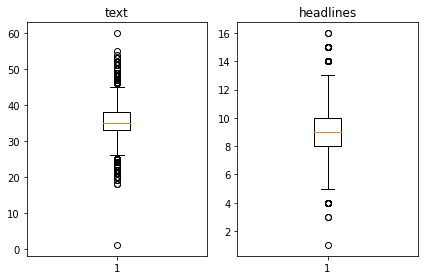

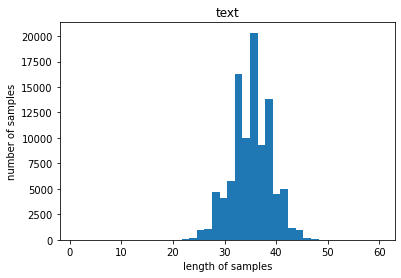

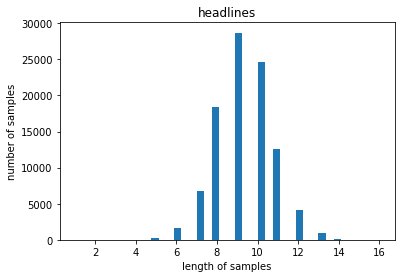

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8165514436762912
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8180866205774705


In [9]:
text_max_len = 38
headlines_max_len = 10

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print(f"텍스트의 최소 길이 : {np.min(text_len)}")
print(f"텍스트의 최대 길이 : {np.max(text_len)}")
print(f"텍스트의 평균 길이 : {np.mean(text_len)}")
print(f"요약의 최소 길이 : {np.min(headlines_len)}")
print(f"요약의 최대 길이 : {np.max(headlines_len)}")
print(f"요약의 평균 길이 : {np.mean(headlines_len)}")

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

기사와 요약의 최소, 최대, 평균 길이와 길이 분포를 시각화하였다.<br>
전체 데이터의 약 80% 정도가 포함되는 길이를 선정하였다.

In [10]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data.reset_index(drop=True, inplace=True)

전체 데이터의 약 80% 정도가 포함되는 길이 이외의 데이터 제거

In [11]:
data['decoder_input'] = SOS_TOKEN + " " + data['headlines']
data['decoder_target'] = data['headlines'] + " " +EOS_TOKEN

디코더의 입력값은 `sostoken`를 앞에, 타겟값은 `eostoken`를 붙여 데이터를 생성

In [12]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

인코더의 입력, 디코더의 입력, 타겟 값을 `np.array` 형식으로 변경

In [13]:
# index shuffle
shuffle_idx = data.index.to_list()
news_valid_len = int(len(shuffle_idx) * 0.2)

np.random.shuffle(shuffle_idx)

encoder_input = encoder_input[shuffle_idx]
decoder_input = decoder_input[shuffle_idx]
decoder_target = decoder_target[shuffle_idx]

# 학습과 테스트, 점증 데이터 분리

encoder_input_train = encoder_input[:-news_valid_len]
decoder_input_train = decoder_input[:-news_valid_len]
decoder_target_train = decoder_target[:-news_valid_len]

encoder_input_test = encoder_input[-news_valid_len:]
decoder_input_test = decoder_input[-news_valid_len:]
decoder_target_test = decoder_target[-news_valid_len:]

전처리를 하면서 `DataFrame.reset_index`를 하였기 때문에 인덱스는 순서대로 정렬되어있으며<br>
이 인덱스의 순서를 랜덤하게 섞은 뒤, 각 데이터에 적용시켜 순서를 랜덤하게 섞는다.<br>
학습과 검증, 테스트데이터 분리는 2:8비율로 하였다.

In [14]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

인코더 문장(`기사`)에 대한 토크나이저를 생성하며<br>
단어집합을 생성한다.

In [15]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f"단어 집합(vocabulary)의 크기 : {total_cnt}")
print(f"등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}")
print(f"단어 집합에서 희귀 단어의 비율: {(rare_cnt / total_cnt)*100}")
print(f"전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {(rare_freq / total_freq)*100}")

단어 집합(vocabulary)의 크기 : 57331
등장 빈도가 5번 이하인 희귀 단어의 수: 37919
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19412
단어 집합에서 희귀 단어의 비율: 66.14048246149554
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.0066457560982744


전체 빈도 횟수를 6번 미만 빈도의 단어를 선정하였으며<br>
빈도 비율은 4%를 넘지 않게 설정하였다.

In [16]:
src_vocab = 19448
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

단어 집합을 희귀단어를 제외한 후의 단어집합 크기로 설정하였으며 그 수는 19448개이다.<br>
인코더의 택스트에 한해 시퀸스화 시켜준다.

In [17]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

디코더 문장(`요약`)에 대한 토크나이저를 생성하며<br>
단어집합을 생성한다.

In [18]:
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print(f"단어 집합(vocabulary)의 크기 : {total_cnt}", )
print(f"등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 {total_cnt - rare_cnt}")
print(f"단어 집합에서 희귀 단어의 비율: {(rare_cnt / total_cnt)*100}")
print(f"전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {(rare_freq / total_freq)*100}")

단어 집합(vocabulary)의 크기 : 25902
등장 빈도가 2번 이하인 희귀 단어의 수: 12997
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12905
단어 집합에서 희귀 단어의 비율: 50.1775924639024
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2196947615105693


전체 빈도 횟수를 3번 미만 빈도의 단어를 선정하였으며<br>
빈도 비율은 4%를 넘지 않게 설정하였다.

In [19]:
tar_vocab = 12872
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

단어 집합을 희귀단어를 제외한 후의 단어집합 크기로 설정하였으며 그 수는 12872개이다.<br>
인코더의 택스트에 한해 시퀸스화 시켜준다.

In [20]:
drop_train = set([index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1])
drop_test = set([index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1])

print(f"삭제할 훈련 데이터의 개수 : {len(drop_train)}")
print(f"삭제할 테스트 데이터의 개수 : {len(drop_test)}")

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print(f"훈련 데이터의 개수 : {len(encoder_input_train)}")
print(f"훈련 레이블의 개수 : {len(decoder_input_train)}")
print(f"테스트 데이터의 개수 : {len(encoder_input_test)}")
print(f"테스트 레이블의 개수 : {len(decoder_input_test)}")

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 52372
훈련 레이블의 개수 : 52372
테스트 데이터의 개수 : 13093
테스트 레이블의 개수 : 13093


빈 문장을 제거한다.<br>
`sostoken`, `eostoken`토큰의 갯수를 포함한 문장이기 때문에 빈 문장의 길이는 1이 된다.<br>
실행결과 제거되는 문장은 없다.

In [21]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

각 문장의 길이를 맞추기위해 padding을 뒤에 집어넣는다.

### 모델 설계

In [22]:
# 인코더
encoder_inputs = Input(shape=(text_max_len,), name="enc_input")

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, EMBEDDING_DIM, name="enc_emb")(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4, name="enc_lstm_1")
# encoder_lstm1 = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_2")
# encoder_lstm2 = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_3")
# encoder_lstm3 = LSTM(HIDDEN_SIZE, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [23]:
# 디코더 설계
decoder_inputs = Input(shape=(None,), name="dec_input")

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, EMBEDDING_DIM, name="dec_emb")
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2, name="dec_lstm")
# decoder_lstm = LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

Variational Dropout을 각 lstm레이어마다 구형을 했으며 `recurrent_dropout`은 <br>
이전의 정보를 가지는 파라미터기 아닌 새로 들어온 파라미터에 대해서만 dropout을 적용하는 파라미터이다.<br>
`NDVIA`에서 제공하는 연산가속 커널 `cuDNN`을 사용하지 못한다는 경고가 나온다.

In [24]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax', name="attention_softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs, name="attention_model")
model.summary()

Model: "attention_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 enc_emb (Embedding)            (None, 38, 128)      2489344     ['enc_input[0][0]']              
                                                                                                  
 enc_lstm_1 (LSTM)              [(None, 38, 256),    394240      ['enc_emb[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                    

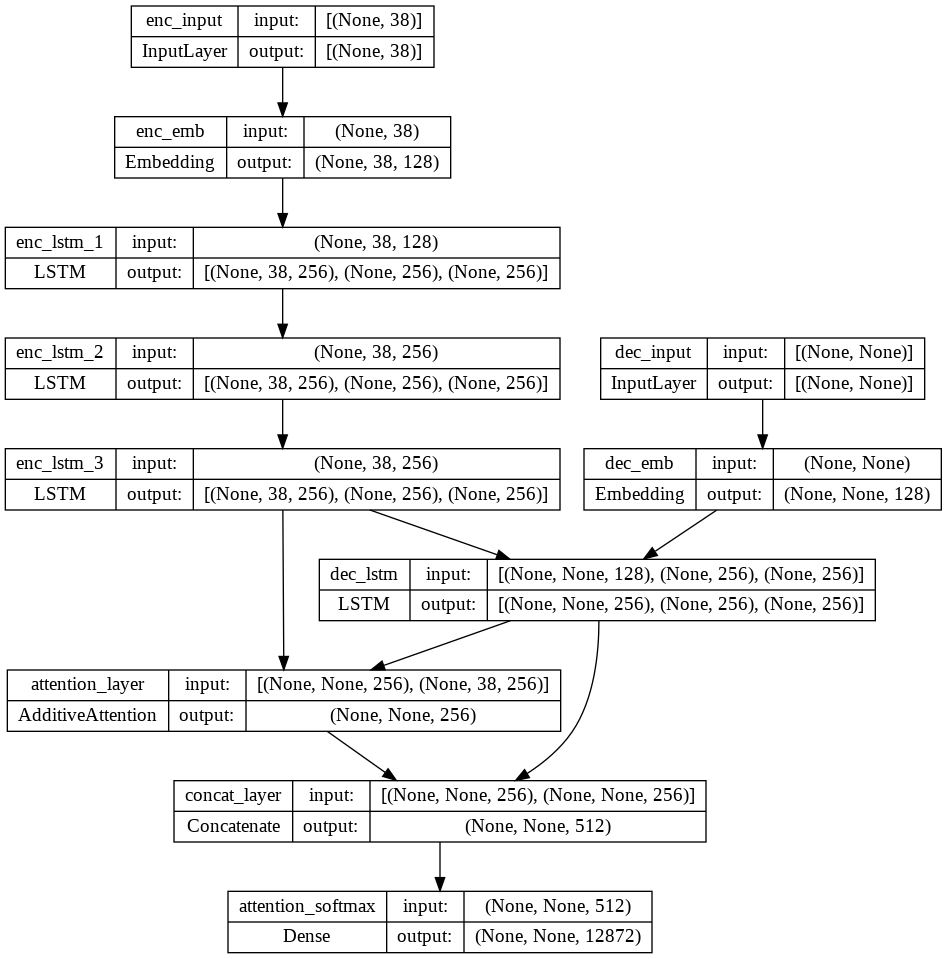

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

모델의 구조가 복잡하기 때문에 모델도를 그렸으며 레이어는 위와 같다.<br>
이전과는 다르게 attention 레이어가 새롭게 생겼으며 38개의 각각의 시퀀스를<br>
tanh, softmax등의 계산을 통해 가중치를 구하는 부분이 있음을 알 수 있다.

Epoch 1/50
819/819 [==============================] - 385s 458ms/step - loss: 6.2780 - acc: 0.2064 - val_loss: 5.7931 - val_acc: 0.2341
Epoch 2/50
819/819 [==============================] - 372s 454ms/step - loss: 5.6405 - acc: 0.2422 - val_loss: 5.4099 - val_acc: 0.2618
Epoch 3/50
819/819 [==============================] - 369s 451ms/step - loss: 5.3237 - acc: 0.2673 - val_loss: 5.2163 - val_acc: 0.2796
Epoch 4/50
819/819 [==============================] - 370s 452ms/step - loss: 5.1139 - acc: 0.2866 - val_loss: 5.0334 - val_acc: 0.2944
Epoch 5/50
819/819 [==============================] - 368s 449ms/step - loss: 4.9575 - acc: 0.3013 - val_loss: 4.9493 - val_acc: 0.3045
Epoch 6/50
819/819 [==============================] - 368s 449ms/step - loss: 4.8445 - acc: 0.3127 - val_loss: 4.9001 - val_acc: 0.3109
Epoch 7/50
819/819 [==============================] - 370s 452ms/step - loss: 4.7618 - acc: 0.3210 - val_loss: 4.8681 - val_acc: 0.3147
Epoch 8/50
819/819 [============================

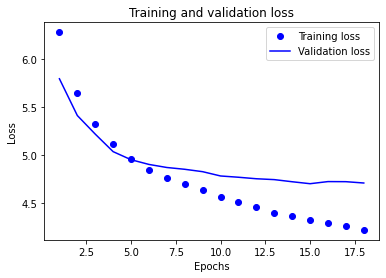

In [26]:
fit_kwargs['validation_data'] = ([encoder_input_test, decoder_input_test], decoder_target_test)

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.002)
    , loss="sparse_categorical_crossentropy", metrics=['acc']
)
history_dict = model.fit(
            x=[encoder_input_train, decoder_input_train]
            , y=decoder_target_train
            , **fit_kwargs).history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

학습결과 우하향하는 그래프의 모습을 보이며<br>
약 7번째부터 train loss, validation loss 의 차이가 크게 벌어진다.

### 검증


In [27]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

inference모델생성을 위해 위의 값을 생성하였다.

In [38]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(HIDDEN_SIZE,))
decoder_state_input_c = Input(shape=(HIDDEN_SIZE,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
(
    decoder_outputs2
    , state_h2
    , state_c2
) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [39]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, HIDDEN_SIZE))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs_inf = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf] + [state_h2, state_c2])

만들어야 할 문장의 단어길이만큼 디코더가 반복 구조로 동작해야하므로 인코더와 디코더를 따로만듬<br>
이때, 기존에 만들었던 `LSTM`의 `hidden cell`을 재사용한다.<br>

In [52]:
for i in range(0, 5):
    print("전처리한 기사 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len), text_max_len))
    print("\n")

전처리한 기사 : us federal communications commission ordered new york city resident shut bitcoin mining interfered mobile wireless network order issued regulator started receiving complaints telecom operator said resident could face fines seizure device keeps operating bitcoin miner 
실제 요약 : bitcoin in new york with mobile network 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  us confirms its own cryptocurrency


전처리한 기사 : national conference chief farooq abdullah threatened party boycott assembly lok sabha elections centre clear position article earlier nc threatened boycott upcoming panchayat elections citing concern supreme court currently hearing petitions challenging constitutional validity article 
실제 요약 : abdullah threatens boycott of election over article 
1/1 [==============================] - 0s 16ms/step
예측 요약 :  opposition leader demands political party for political party


전처리한 기사 : announcing sp bsp alliance general elections sp president akhilesh yadav said bjp

순서대로 `원문(data)`, `실제 요약(target)`, `학습을 통해 나온 요약`을 출력하였다.<br>
추상적 요약방식이므로 핵심단어가 들어가고 단어가 달라도 문장이 어느정도 핵심단어를 포함하고 있으나<br>
단어가 반복되는 페턴이 보인다.

In [64]:
data_ori = pd.read_csv(DATA_PATH, encoding='iso-8859-1')
for t, h in zip(data_ori["text"][:5],data_ori["headlines"][:5]):
    print("전처리한 기사 :", t)
    print("실제 요약 :", h)
    print("예측 요약 :", summarize(t ,ratio=0.45))
    print("\n")

전처리한 기사 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


전처리한 기사 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee o

순서대로 `원문(data)`, `실제 요약(target)`, `summa 라이브러리를 이용한 요약`을 출력하였다.<br>
핵심단어가 포함되어있으나 문장의 요지를 잘못짚은 경우가 대다수인 것을 볼수 있다.


분석한 결과는 아래와 같다.<br>
||Extractive 요약|Abstractive 요약|
|:-----------------------|---------------------------:|---------------------:| |문법 완성도 |상대적 완성도 높음| 문법 완성도 낮음 |
| 핵심던어 포함  |  핵심단어를 잘 포함 |학습에 따라 핵심단어 포함 정도가 다름|
|비고 |text의 앞 뒤 문장 중 일부를 잘라 표현하는 경향이 큼|전체적으로 모델과 학습에 영향을 많이 받음|